#### Notebook to fine tune XGB Model iteratively  

**This notebook predicts LOS Range given patient demographics, primay Diagnosis, Diagnosis category and comorbidities**  
  
The documentation from running this notebook can be found here  
https://docs.google.com/document/d/1_tSFTbfdEpRJQDMnX80gbnbjrtx27ItaFDr-a9VtwYM/edit#heading=h.bcgr7o6ziqp0

### Step 1: Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import time

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn import *

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 12

### Step 2: Load the data file

In [2]:
rawdata = pd.read_csv('data/NVtoDTDRange8.csv', index_col=[0])

data = rawdata.copy()
print(data.shape)

(9173, 948)


### Step 3 Preprocess the data for the model 

In [3]:
CatgCols = ['Gender', 'Ethinicity', 'Religion', 'MaritalStatus',
       'DiagnosisCategory', 'PrimaryDiag', 'DiagGroup']

### Eliminate some noise based on data exploration
# data[CatgCols[4]].value_counts()
# Make PrimaryDiag = Other if only one patient
v = data['PrimaryDiag'].value_counts() == 1 
data.loc[data['PrimaryDiag'].isin(v.index[v]), 'PrimaryDiag'] = 'Other'
# Make Religion = Other if less than 5 patients
v = data['Religion'].value_counts() < 5  
data.loc[data['Religion'].isin(v.index[v]), 'Religion'] = 'Other'
# Make DiagnosisCategory = Other if less than 10 patients
v = data['DiagnosisCategory'].value_counts() < 10  
data.loc[data['DiagnosisCategory'].isin(v.index[v]), 'DiagnosisCategory'] = 'Other'
# Make DiagGroup = Other if less than 10 patients
v = data['DiagGroup'].value_counts() < 10  
data.loc[data['DiagGroup'].isin(v.index[v]), 'DiagGroup'] = 'Other'
# Make Ethinicity = Other if less than 10 patients
v = data['Ethinicity'].value_counts() < 10  
data.loc[data['Ethinicity'].isin(v.index[v]), 'Ethinicity'] = 'Other'

### TODO  "Create a pipeline function to deal with unseen categories"

In [4]:
#Drop text column DiagDesc 
data.drop(columns='DiagDesc', inplace=True)

#encode categorical columns
le = preprocessing.LabelEncoder()
data = rawdata
data[CatgCols].values.flatten()
le.fit(data[CatgCols].values.flatten().astype(str))
data[CatgCols] = le.transform(data[CatgCols].values.flatten().astype(str)).reshape(data[CatgCols].shape)

# encode predictor variable
lep = preprocessing.LabelEncoder()
lep.fit(data.LosRange)
lep_dict = dict(zip(lep.classes_, lep.transform(lep.classes_)))
print(lep_dict)
data.LosRange = lep.transform(data.LosRange)


{'0:<7': 0, '1:7-14': 1, '2:15-21': 2, '3:22-30': 3, '4:31-60': 4, '5:61-120': 5, '6:121-180': 6, '7:180+': 7}


**Adjust class sizes by sampling proportionally or uniformly**

In [5]:
print(data['LosRange'].value_counts())
ZZ = data.groupby('LosRange', group_keys=False).apply(lambda x: x.sample(frac=1, replace=True))
print(ZZ['LosRange'].value_counts())
ZZ.shape

0    2062
7    1958
5    1193
4    1160
1    1069
6     580
3     577
2     574
Name: LosRange, dtype: int64
0    2062
7    1958
5    1193
4    1160
1    1069
6     580
3     577
2     574
Name: LosRange, dtype: int64


(9173, 948)

**Save Mean LOS for the class for bias/variance evaluation**

In [6]:
XX=ZZ.groupby('LosRange', as_index=False)['TotalLos'].mean()
los_class_mean_map = dict(zip(XX.LosRange, XX.TotalLos))
los_class_mean_map

{0: 3.387002909796314,
 1: 10.570626753975679,
 2: 17.782229965156795,
 3: 25.788561525129982,
 4: 43.985344827586204,
 5: 86.75523889354568,
 6: 148.75172413793103,
 7: 439.2778345250255}

**Choose target and unused columns in the dataset**  
Filter out columns/rows if chosing to build model for a specific group/category of observations

In [7]:
## Ignore the first three columns (LosRange, EntitySys, TotalLOS and )
target='LosRange'
NonFeatureCols =['LosRange','EntitySys','TotalLos','DiagDesc', 'DTDsinceVD','AdmitMonth']   # always include predictor
featureList = [x for x in data.columns if x not in NonFeatureCols]

### Step 4 Split Train and Test Data sets for validating the model

In [8]:
# Create matrices and dataframes for train/test
X = ZZ[featureList]
y = ZZ[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32)
dtrain, dtest = train_test_split(ZZ, test_size=0.25, random_state=32, shuffle=True, stratify=y)

**Deal with missing values in train and test**

In [9]:
my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
train_X = my_imputer.fit_transform(X_train)
test_X = my_imputer.transform(X_test)
#dtrain = my_imputer.fit_transform(dtrain)
#dtest = my_imputer.transform(dtrain)

**Find class weights as model to prevent bias towards larger classes**

In [10]:
print(dtrain['LosRange'].value_counts().sum())
print(np.array(dtrain['LosRange'].value_counts()))
class_weights = dtrain['LosRange'].value_counts().mean()/np.array(dtrain['LosRange'].value_counts())
class_weights/np.mean(class_weights)

6879
[1546 1468  895  870  802  435  433  430]


array([0.43943946, 0.46278842, 0.75907642, 0.78088896, 0.847099  ,
       1.56177793, 1.56899168, 1.57993813])

In [11]:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=dtrain[target] #provide your own target name
)
pd.Series(sample_weights).value_counts()

0.556193    1546
0.585746    1468
0.960754     895
0.988362     870
1.072163     802
1.976724     435
1.985855     433
1.999709     430
dtype: int64

### Import Functions for use in tuning the model

In [12]:
%load_ext autoreload
%autoreload 2
import XGBFunctions as myf
#imports the following functions
#   printPredictions(alg, X, y, featureList):
#   printResults(alg, X, y, featureList):
#   modelfit(alg, xtrain, ytrain, target, featureList,useTrainCV=True, 
#            cv_folds=5, early_stopping_rounds=50):
#   printModelStats(model, dtrain, dtest, featureList, target):
#   save_tree(xgb_model, filename, rankdir='UT'):
#   show_tree(model):
#   xgbfit(alg, xtrain, ytrain, featureList):

### Experiment Cell start here.  
Modify the parameters for each run and document the results. 

**Change parameters and run to record results**


Model Report
Accuracy  : 1.0000
Precision : 1.0000
Recall    : 1.0000
Balanced Accuracy  : 1.0000
Precision(wtd) : 1.0000
Recall(wtd)    : 1.0000
Balanced Accuracy(adj)  : 1.0000
Model Fit Time 00h:00m:22s


Training Predictions
Accuracy: 100.00%
Precision Score: 1.00000
Recall: 1.00000
[[1546    0    0    0    0    0    0    0]
 [   0  802    0    0    0    0    0    0]
 [   0    0  430    0    0    0    0    0]
 [   0    0    0  433    0    0    0    0]
 [   0    0    0    0  870    0    0    0]
 [   0    0    0    0    0  895    0    0]
 [   0    0    0    0    0    0  435    0]
 [   0    0    0    0    0    0    0 1468]]
Test Predictions
Accuracy: 78.51%
Precision Score: 0.78915
Recall: 0.74518
[[449  24   4   6  15   5   1  12]
 [ 31 197   2   1  14   8   2  12]
 [  8   6 104   3   3  11   2   7]
 [ 16   9   2  88   7  12   2   8]
 [ 20  10   3   2 213  16   9  17]
 [ 13  16   4   3  16 216   4  26]
 [  8   2   2   0   4  15  97  17]
 [  8  13   1   0  17   8   6 437]]
Number of 

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.3,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.3,
 'max_delta_step': 0,
 'max_depth': 8,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 32,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 77,
 'reg_alpha': 0.002,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 0.4,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0,
 'num_class': 8,
 'max_bin': 5,
 'eval_metric': 'mlogloss',
 'seed': 77,
 'nthreads': -1}

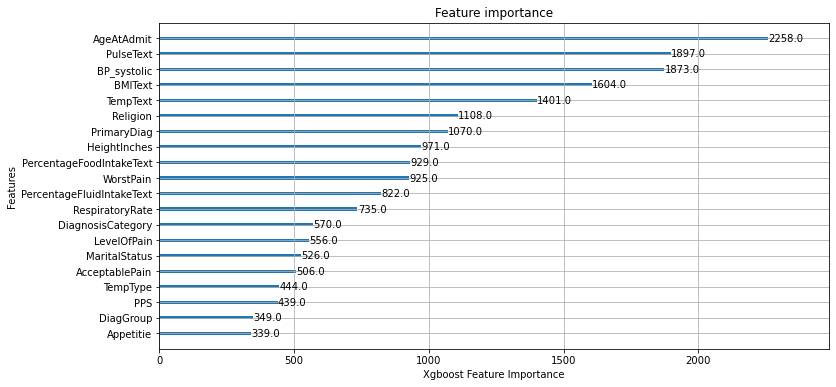

In [13]:
from xgboost import XGBClassifier
xgb100 = XGBClassifier(
    n_estimators=400,           # num_boosting_rounds passed to fit function
    num_class=8,                # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,  # only for gpu_hist tree methods

    # general parameters
    max_depth= 8,              # default=6 (3-10) lower  underfits
    colsample_bytree= .3,       # cols to sample for each tree
    max_bin=5,                 ## minuimum 2  This parameter has no effect on anything. Manual Grid search.
    learning_rate = 0.3,
    verbosity= 0,              # 0:silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       ## default=1        higher underfits Train and test consistently.
    gamma=0,                   ## depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,       # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= .4,             # sample observations for each tree 1 means all
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=1,              # L2 regularization evenly reduce of wts
    reg_alpha=0.002,               # L1 regularization eliminate weights randomly 
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'mlogloss',
    seed= 77,                  # reproducible for parameter tuning. 
    tree_method= 'exact',      # based on column histograms rather than reading observations every time.

    base_score= 0.5,           ## initial prediction score for all instances (global bias)
    random_state= 77,
    validate_parameters= 1,
    nthreads=-1
)
start_time = time.time()
myf.xgbfit(xgb100, dtrain[featureList], dtrain[target], featureList)
elapsed = time.time() - start_time
print('Model Fit Time %s\n\n' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
myf.printModelStats(xgb100, dtrain, dtest, featureList, target)
xgb100.get_xgb_params()

In [14]:
## Model Performance in how close predictions are to actual LOS

los = dtest['TotalLos'].values
pred = xgb100.predict(dtest[featureList])
pred_los = pd.Series(pred).map(los_class_mean_map).values
dtest.insert(0,'Pred_Los', pred_los)




In [15]:
#loss_deviance is the deviance individual LOS from the class mean
los_deviance = pd.Series(dtest[target]).map(los_class_mean_map).values
diffs = abs(los_deviance-pred_los).round(0).astype(int)  # is specific to the individual's los

bins =  [-1,   7,      14,           30,          60,        90,         120,        np.inf]
names = ['a:+/-7','b:+/-14',   'c:+/-30',   'd:+/-60',   'e:+/-90', 'f:+/-120',   'g:+180']

print(pd.cut(abs(diffs), bins, labels=names).value_counts())

a:+/-7      1864
b:+/-14       17
c:+/-30       47
d:+/-60       91
e:+/-90       91
f:+/-120      13
g:+180       171
dtype: int64


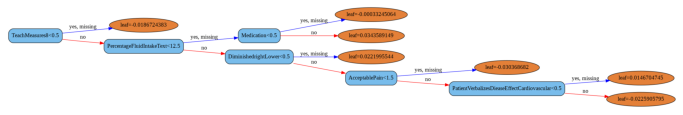

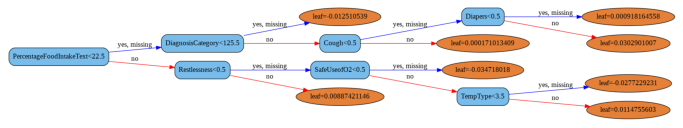

In [16]:
for x in range(3000,3002):
    myf.show_tree(xgb100,tree_num=x)

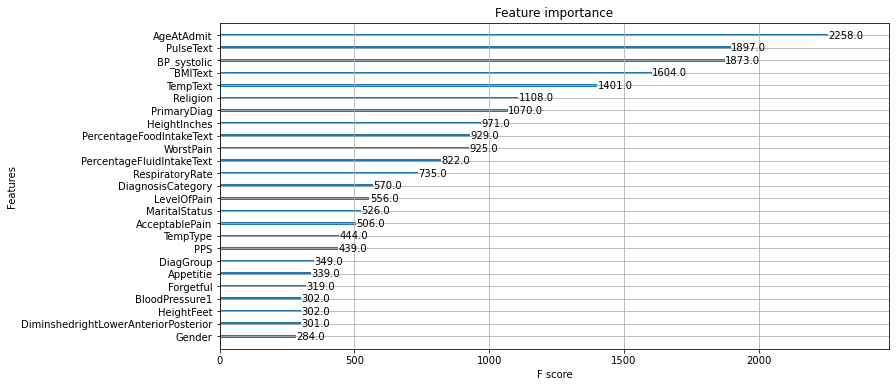

In [17]:
xgb.plot_importance(xgb100, max_num_features=25)

**Combine Predictions with training data and save results**

In [18]:

pred = xgb100.predict(dtrain[featureList])
pred_los = pd.Series(pred).map(los_class_mean_map).values
dtrain.insert(0,'Pred_Los',pred_los)

In [19]:
CatgCols = [ 'Ethinicity', 'Religion', 'MaritalStatus',
       'DiagnosisCategory', 'PrimaryDiag', 'DiagGroup','Gender']
for col in CatgCols:
    xx = pd.Series(le.inverse_transform(dtrain[col]))
    dtrain.loc[:,col] =xx.copy()
    yy = pd.Series(le.inverse_transform(dtest[col]))
    dtest.loc[:,col] = yy.copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
dtrain.to_csv('TrainResults.csv')
dtest.to_csv('TestResults.csv')